<a href="https://colab.research.google.com/github/varunSabnis/pytorch_course_udemy/blob/master/MNIST_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision

In [0]:
import torch
from torchvision import datasets, transforms
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))]) # mean and standar deviation of 0.5 for channel 1, here image has only one channel
training_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
def image_convert(im_tensor):
  image = im_tensor.clone().detach().numpy() 
  image = image.transpose(1, 2, 0) # Change shape of image from 1*28*28 to 28*28*1
  image = image*(np.array((0.5, 0.5, 0.5))) + np.array((0.5, 0.5, 0.5)) 
  """
  y = (x - mean)/std
  x = y*std + mean  -- this will get back original image that was normalized
  """
  image = image.clip(0, 1) # Keep every pixel between 0 and 1
  return image

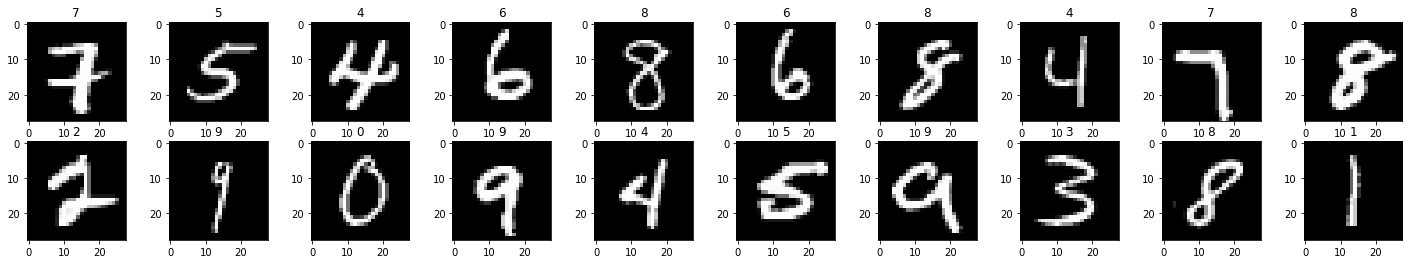

In [5]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
  ax = fig.add_subplot(2, 10, i+1)
  plt.imshow(image_convert(images[i]))
  ax.set_title(labels[i].item())


In [0]:
class Classifier(nn.Module):

  def __init__(self, input_size, H1, H2, output_size):
    super().__init__()
    self.linear1 = nn.Linear(input_size, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, output_size)

  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x

In [0]:
def get_image_shape(images):
  image = image_convert(images[0])
  im_shape = image.shape[0]*image.shape[1]
  return(im_shape)

In [8]:
im_shape = get_image_shape(images)
model = Classifier(im_shape, 125, 65, 10) 
model 

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [10]:
epochs = 12
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

print("len of training loader {}".format(len(training_loader)))
print("len of validation loader {}".format(len(validation_loader)))
for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  validation_running_loss = 0.0
  validation_running_corrects = 0.0
  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)
    running_loss += loss.item()
  with torch.no_grad():
    for val_inputs, val_labels in validation_loader:
      val_inputs = val_inputs.view(val_inputs.shape[0], -1)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      _, val_preds = torch.max(val_outputs, 1)
      validation_running_corrects += torch.sum(val_preds == val_labels.data)
      validation_running_loss += val_loss.item()

  epoch_loss = running_loss/(len(training_loader))
  acc = running_corrects/(len(training_loader))
  val_epoch_loss = validation_running_loss/(len(validation_loader))
  val_acc = validation_running_corrects/(len(validation_loader))

  val_running_loss_history.append(val_epoch_loss)
  running_loss_history.append(epoch_loss)
  running_correct_history.append(acc)
  val_running_correct_history.append(val_acc)

  print("training loss : {:.4f} training accuracy : {:.2f}".format(epoch_loss, acc))
  print("Validation loss : {:.4f} Validation accuracy : {:.2f}".format(val_epoch_loss, val_acc))

len of training loader 600
len of validation loader 100
training loss : 0.9789 training accuracy : 76.06
Validation loss : 0.4383 Validation accuracy : 88.38
training loss : 0.3862 training accuracy : 89.24
Validation loss : 0.3375 Validation accuracy : 90.73
training loss : 0.3239 training accuracy : 90.54
Validation loss : 0.2958 Validation accuracy : 91.77
training loss : 0.2931 training accuracy : 91.53
Validation loss : 0.2700 Validation accuracy : 92.10
training loss : 0.2704 training accuracy : 92.15
Validation loss : 0.2507 Validation accuracy : 92.79
training loss : 0.2499 training accuracy : 92.71
Validation loss : 0.2366 Validation accuracy : 93.03
training loss : 0.2310 training accuracy : 93.35
Validation loss : 0.2211 Validation accuracy : 93.53
training loss : 0.2138 training accuracy : 93.88
Validation loss : 0.2056 Validation accuracy : 94.03
training loss : 0.1988 training accuracy : 94.30
Validation loss : 0.1948 Validation accuracy : 94.36
training loss : 0.1857 tra

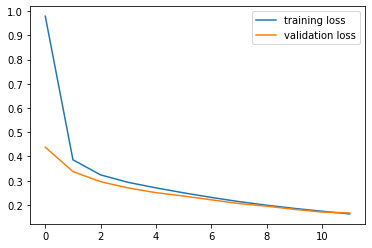

In [11]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.legend()

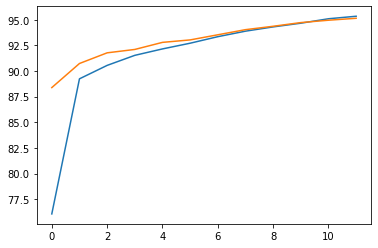

In [12]:
plt.plot(running_correct_history, label="training accuracy")
plt.plot(val_running_correct_history, label="validation accuracy")